# Hendricks Group

# Hidden Ancestry Correlated Data Simulations

_In the following notebook, we investigate the effect of correlated observations on the numerical solution to the Hidden Ancestries problem.
In particular, we consider a series of solutions to problems in which we have repeated observations in our data set.
Repeated observations are simply equal data, which are perfectly correlated.
We use simulated SNPs with minor allele frequencies for only 2 ancestries -- European ancestries and African ancestries.
We try to solve for both ancestry's proportions in the total (simulated) population. 
In detail, we choose known ancestry proportions (we choose our own answer!) and ensure that our Python script correctly uses the data to solve for the ancestry proportions. Here, we have the case in which the European ancestries comprise $0.1$ of the total population and African ancestries comprise $0.9$ of the total population.
Although this data contain $>77,000$ SNPs, we will only be using about 10 of these for now..._

In [1]:
# This calls the generalized HA script -- be sure to have it saved in you working directory!
# This cell is not going to work once you change your working directory in the next cell to read in data!!!!!
# Changing your working directory is totally unneccessary if you are working in the "nfs" based directory already

%run HA_script.py

In [252]:
import os
import pandas as pd

# Change the current working directory to read in data
# Note that eventually we will need to upload this data along with our package...
os.chdir('/nfs/storage/math/gross-s2/projects/mixtures/example_sims/')

# Read in the data
ev = pd.read_csv("Afr_CEU_10000tot_9900Afr_sims_and_reference.txt", sep='\t')

print(ev.head(10))### Look at the first 5 rows

print(np.shape(ev),np.shape([ev['CEU_MAF']]),ev.columns,ev.columns[2],np.shape(ev[ev.columns[2]]))

   CHR         SNP  CEU_MAF   afr_MAF  sample_af
0    1   rs1003699   0.0404  0.155752    0.15495
1    1  rs10047127   0.1162  0.186525    0.18705
2    1   rs1007263   0.1263  0.034723    0.03755
3    1   rs1007788   0.4747  0.474220    0.47225
4    1  rs10082023   0.2929  0.342261    0.34245
5    1   rs1010470   0.3434  0.462320    0.46430
6    1  rs10127654   0.0000  0.094270    0.08955
7    1   rs1013665   0.1414  0.014880    0.01585
8    1  rs10157240   0.4646  0.225209    0.22910
9    1  rs10157264   0.0000  0.050598    0.04880
(76260, 5) (1, 76260) Index(['CHR', 'SNP', 'CEU_MAF', 'afr_MAF', 'sample_af'], dtype='object') CEU_MAF (76260,)


In [253]:
N = 76260

A = np.zeros((N,2))
names = ev.columns

for i in range(2,4):
    A[:,i-2] = ev[names[i]]

a_t = np.zeros((N,1))
a_t[:,0] = ev[names[4]]
print(np.shape(A),np.shape(a_t))

print()

print(A[0:10,:])

print()

print(a_t[0:10,:])

(76260, 2) (76260, 1)

[[0.0404     0.15575218]
 [0.1162     0.1865252 ]
 [0.1263     0.0347231 ]
 [0.4747     0.47422024]
 [0.2929     0.34226091]
 [0.3434     0.46231984]
 [0.         0.09426984]
 [0.1414     0.01487994]
 [0.4646     0.22520893]
 [0.         0.05059833]]

[[0.15495]
 [0.18705]
 [0.03755]
 [0.47225]
 [0.34245]
 [0.4643 ]
 [0.08955]
 [0.01585]
 [0.2291 ]
 [0.0488 ]]


In [254]:
# Perform checks and print results
print('number of SNPs is', np.shape(a_t)[0])

print()

print('and our input matrix is size', np.shape(A))

number of SNPs is 76260

and our input matrix is size (76260, 2)


In [255]:
pca_n = N

import sklearn
from sklearn.preprocessing import StandardScaler
std_A = StandardScaler().fit_transform(A[0:pca_n,:])
std_a_t = StandardScaler().fit_transform(a_t[0:pca_n,:])
print(std_A[0:10,:])

[[-0.37198107  0.22613576]
 [ 0.15407252  0.46293553]
 [ 0.22416674 -0.70518866]
 [ 2.64207007  2.67676214]
 [ 1.38037424  1.66132904]
 [ 1.73084531  2.58518804]
 [-0.65235792 -0.2469737 ]
 [ 0.32896105 -0.85788262]
 [ 2.57197586  0.76060862]
 [-0.65235792 -0.58302797]]


In [256]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(std_A)

print(pca.explained_variance_ratio_)

print()

print(pca.singular_values_)

print()

print(pca.components_)

[0.79562434 0.20437566]

[348.35129376 176.55417337]

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


In [262]:
# Classify responses

target = []

for i in range(0,pca_n):
    if np.abs(0.01*A[i,0]+0.99*A[i,1]-a_t[i])<2e-3:
        target.append('good')
    else:
        target.append('bad')
targetDf = pd.DataFrame(data=target, columns = ['target'])        

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, targetDf], axis = 1)

print(finalDf.head(5))

   principal component 1  principal component 2 target
0              -0.103128              -0.422932   good
1               0.436291              -0.218399   good
2              -0.340134               0.657154   good
3               3.760982              -0.024531   good
4               2.150809              -0.198665   good


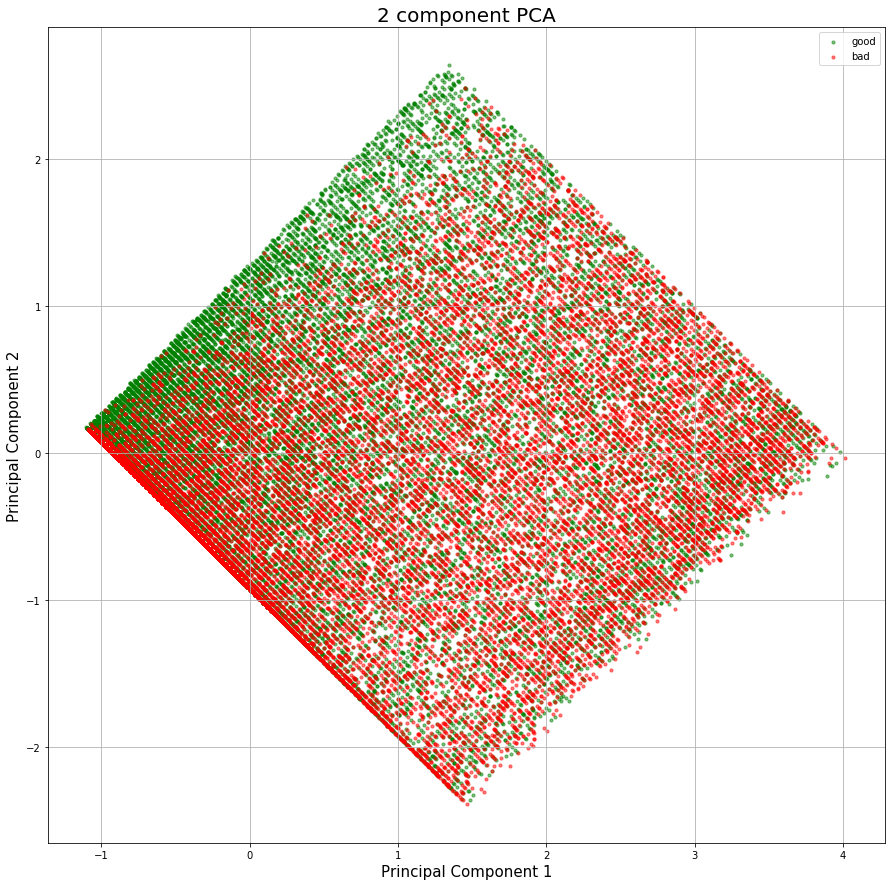

In [263]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['good', 'bad']
colors = ['green', 'red']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10
               , alpha = 0.5)
ax.legend(targets)
ax.grid()

plt.show()

## Before we do simulations we (1) choose an initial starting guess to seed all of our runs with (2) we solve the problem with all $77,095$ SNPs just as a baseline

In [264]:
# The real answer is (.01,.99) for the data set we just read in.
# Therefore, we choose a starting guess sufficiently far away

x_t=np.transpose([[.5,.5]])

In [265]:
# Ensure that the starting guess is proper size
# SHould be kx1

x_t.shape

(2, 1)

In [266]:
what_we_want = HA(A, a_t, x_t)

print('solution using every SNP:', what_we_want[0])

print()

#print('exact solution should be:', [0.01,0.99])

solution using every SNP: [0.00999064 0.99000936]



## First: solve ten 1 SNP problems using first ten observations in data frame

In [ ]:
sol_array = np.zeros((10,2))

for i in range(0,10):
    a_1_single_SNP = a_1[i:i+1]
    a_2_single_SNP = a_2[i:i+1]
    a_t_single_SNP = a_t[i:i+1]


    # Now stack the columns into an input matrix that HA function will accept. Should be size Nxk.
    A_single_SNP = np.hstack((a_1_single_SNP,a_2_single_SNP))

    what_we_want_single_SNP = HA(A_single_SNP, a_t_single_SNP, x_t)[0]
    
    sol_array[i,:] = what_we_want_single_SNP

In [ ]:

print(sol_array)
print(np.shape([[1,2]]))

#### Above we have printed out the 10 solutions we found. Some are good, some are almost perfect (!!!), and some are very bad...

#### In fact, we see that 3 of the SNPs must be relatively un-informative since three of the printed solutions are just the initial starting guess of $x_t=(0.5,0.5)$. In other words, the initial solution was a better solution to these problems than whatever the 1-step of SQP landed on...


#### Need to plot these 10 sols.

## Next: Create a data frame with 1 copy of each of the 10 initial SNPs above.

### We will have 10 total SNPs and solve the problem with all 10 included now. (Just another baseline.)

In [ ]:
A_ten_SNP = np.zeros((10,2))

for i in range(0,10):
    a_1_single_SNP = a_1[i:i+1]
    a_2_single_SNP = a_2[i:i+1]
    a_t_single_SNP = a_t[i:i+1]


    # Now stack the columns into an input matrix that HA function will accept. Should be size Nxk.
    A_ten_SNP[i,:] = np.hstack((a_1_single_SNP,a_2_single_SNP))

    what_we_want_ten_SNP = HA(A_ten_SNP, a_t_single_SNP, x_t)[0]

In [ ]:
print(what_we_want_ten_SNP)

#### Here we see a solution that is close, but about $0.05$ "off" in each component, where we recall the truth is $(0.1,0.9).$

## Next: Create a data frame with 10 copies of each of the 10 initial SNPs.

### Now we will have 100 total SNPs and solve the problem with all 100. I am expecting the same exact solution as what we just got since the ratios of each data observation has not changed... (?)

In [ ]:
A_hund_SNP = np.zeros((100,2))
a_t_hund_SNP = np.zeros((100,1))

for i in range(0,10):
    a_1_single_SNP = a_1[i:i+1]
    a_2_single_SNP = a_2[i:i+1]
    a_t_single_SNP = a_t[i:i+1]

    for j in range(0,10):
        # Now stack the columns into an input matrix that HA function will accept. Should be size Nxk.
        A_hund_SNP[i+j,:] = np.hstack((a_1_single_SNP,a_2_single_SNP))
        a_t_hund_SNP[i+j,:] = a_t_single_SNP

    what_we_want_hund_SNP = HA(A_hund_SNP, a_t_hund_SNP, x_t)[0]


In [ ]:
print(what_we_want_hund_SNP)

#### Wow! Here we see a solution that is actually closer, only about $0.01$ "off" in each component, where we recall the truth is $(0.1,0.9).$

#### Is the effect of the multiple informative SNP's is outweighing the "bad"/uniformative SNPs now?

## Final test for now: Create a data frame with 80 copies of an informative SNP and 20 copies of an uninformative SNP

### Now we will again have 100 total SNPs and solve the problem with all 100. I no longer know what to expect!

### I will use the very first initial SNP for copying 80 times since it was informative

### I will use the second initial SNP for copying 20 times since it seemed uninformative (only based on its single SNP solution...)

In [ ]:
good_n = 80
bad_n = 20 # these two values must sum to 100!

A_hund_SNP_1 = np.zeros((100,2))
a_t_hund_SNP_1 = np.zeros((100,1))


a_1_good_SNP = a_1[0:1]
a_2_good_SNP = a_2[0:1]
a_t_good_SNP = a_t[0:1]

for j in range(0,good_n):
    # Now stack the columns into an input matrix that HA function will accept. Should be size Nxk.
    A_hund_SNP_1[i,:] = np.hstack((a_1_good_SNP,a_2_good_SNP))
    a_t_hund_SNP_1[i,:] = a_t_single_SNP
    
a_1_bad_SNP = a_1[1:2]
a_2_bad_SNP = a_2[1:2]
a_t_bad_SNP = a_t[1:2]

for j in range(0,bad_n):
    # Now stack the columns into an input matrix that HA function will accept. Should be size Nxk.
    A_hund_SNP_1[good_n+i,:] = np.hstack((a_1_bad_SNP,a_2_bad_SNP))
    a_t_hund_SNP_1[good_n+i,:] = a_t_bad_SNP

what_we_want_hund_SNP_1 = HA(A_hund_SNP_1, a_t_hund_SNP_1, x_t)[0]

In [ ]:
print(what_we_want_hund_SNP_1)

#### Very interesting. I am getting the solution above even when I use 99 "bad" SNPs and only 1 "good" SNP... As soon as I take away the only good SNP, we are back to the initial guess, $x_t=(0,5,0.5)$.

#### Need to put in sliders for good_n and bad_n to show this?

#### More investigation needed.